Options:


3. Use rolling ARIMA that worked in thesis 🫡
2. Better tune ARIMA input data and hyperparams ✅

Use historical quarterly returns as input, then only need to predict 1 (next) value.

4. Come up with alternatives because our objective is expected returns, not price (eg. first 10 days/use confidence interval average, etc.)
1. Use another model

In [39]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_URL = "http://localhost:7999"

In [42]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [67]:
exchange_token = "10939" # Nippon India ETF Nifty Next 50 Junior BeES
quarter_end = "2023-09-30"
quarter_start = "2023-07-01"
quarter_prev = (pd.to_datetime(quarter_start) - pd.DateOffset(years=1)).strftime("%Y-%m-%d")
quarter_prev

params = {"start_date": quarter_prev , "end_date": quarter_start}
candles = requests.get(f"{BASE_URL}/tickers/{exchange_token}/candles", params=params).json()
actual_candles = requests.get(f"{BASE_URL}/tickers/{exchange_token}/candles", params={"start_date": quarter_start, "end_date": quarter_end}).json()
len(candles), len(actual_candles)

(247, 63)

In [68]:
df = pd.DataFrame.from_dict(candles, orient="index")
df.index = pd.to_datetime(df.index)
df_actual = pd.DataFrame.from_dict(actual_candles, orient="index")
df_actual.index = pd.to_datetime(df_actual.index)

df_close = df["close"].to_frame()
df_close.head()

df.head()

,open,high,low,close,volume,open_interest
2022-07-01,397.40,397.40,380.00,390.18,96987,0
2022-07-04,399.99,399.99,386.18,392.64,393177,0
2022-07-05,397.96,397.96,385.25,393.98,161099,0
2022-07-06,398.00,400.34,386.25,399.68,110619,0
2022-07-07,413.99,413.99,391.26,404.42,146163,0


In [69]:
m = 4
auto_model = auto_arima(df_close, seasonal=True, m=m)
best_order = auto_model.get_params()["order"]
best_seasonal_order = auto_model.get_params()["seasonal_order"]
best_order, best_seasonal_order

((1, 1, 0), (1, 0, 1, 4))

In [70]:
model = ARIMA(df_close["close"], order=(8, 1, 7))
model_fit = model.fit()
forecast = model_fit.forecast(len(df_actual), alpha=0.05)


/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. U

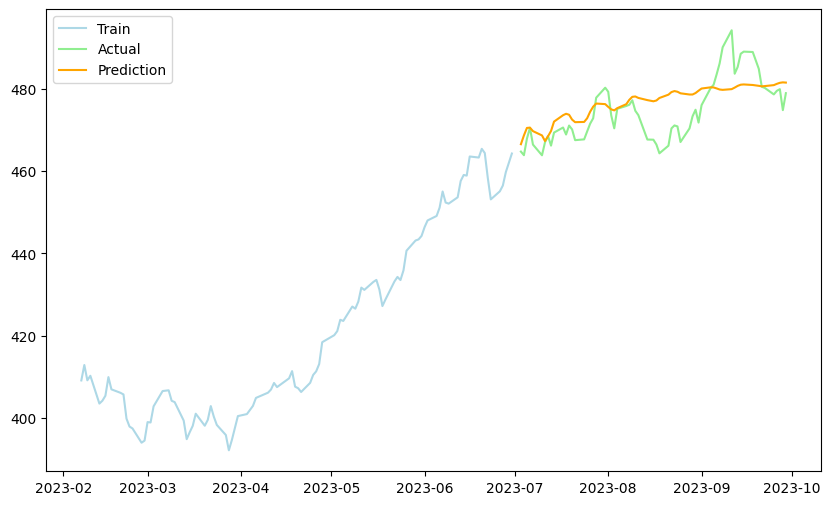

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(df_close.index[150:], df_close["close"][150:], label="Train", color="lightblue")
plt.plot(df_actual.index, df_actual["close"], label="Actual", color="lightgreen")
plt.plot(df_actual.index, forecast, label="Prediction", color="orange")
plt.legend()
plt.show()

Length of test: 63, Length of forecast: 63
Test first 10 values: [464.73, 463.85, 467.88, 470.51, 466.43, 463.83, 466.99, 468.52, 466.18, 469.35]
Forecast first 10 values: [466.5228743758883, 468.6591280795329, 470.4805550020219, 470.5512350839697, 469.7023497993575, 468.6599249214689, 467.2956129792505, 468.44536167012285, 469.7373957276759, 472.01916857147654]
Test last 10 values: [489.03, 488.94, 484.86, 480.49, 480.21, 478.63, 479.5, 479.9, 474.81, 478.93]
Forecast last 10 values: [481.05215013757265, 480.91971276383634, 480.71649989088445, 480.59681808288286, 480.65500231987096, 480.8867998206719, 481.19596892324967, 481.45067381997427, 481.5575834289631, 481.5039259155211]
MAE: 4.577012301951226, MSE: 33.648801677662604, MAPE: 0.009647146866105879


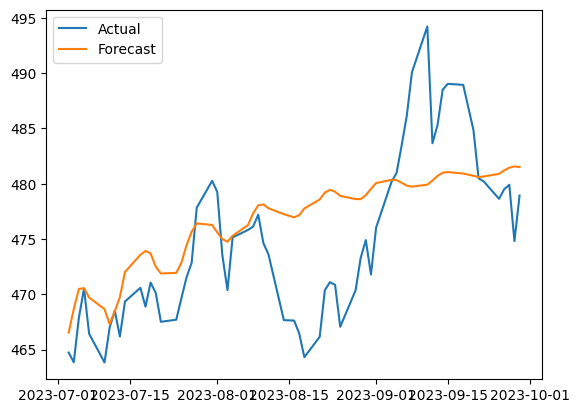

In [72]:
test = list(df_actual["close"].values)
forecast = list(forecast)

print(f"Length of test: {len(test)}, Length of forecast: {len(forecast)}")

print("Test first 10 values:", test[:10])
print("Forecast first 10 values:", forecast[:10])
print("Test last 10 values:", test[-10:])
print("Forecast last 10 values:", forecast[-10:])

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
print(f"MAE: {mae}, MSE: {mse}, MAPE: {mape}")

plt.plot(df_actual.index, test, label='Actual')
plt.plot(df_actual.index, forecast, label='Forecast')
plt.legend()
plt.show()


In [29]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Example historical price data
prices = df_close["close"]

# Calculate daily returns
returns = prices.pct_change().dropna()

# Fit the ARIMA model on returns
model = ARIMA(returns, order=(1, 0, 1))  # Example ARIMA(1,0,1), adjust based on your data
fitted_model = model.fit()

# Forecast future returns for the desired time frame (e.g., 10 days)
forecast_steps = 10
forecasted_returns = fitted_model.forecast(steps=forecast_steps)

# Calculate the average of the forecasted returns
expected_return = forecasted_returns.mean()
expected_return


/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be g

7.015686650640929e-05

In [30]:
average_return = returns.mean()
average_return

7.307015131603379e-05

In [126]:
predicted_returns = pd.DataFrame(forecasted_returns).pct_change().dropna()
predicted_average_return = predicted_returns.mean()
predicted_average_return

predicted_mean   -0.086582
dtype: float64

In [45]:
from statsmodels.tsa.arima.model import ARIMA

df["Quarterly Returns"] = df["close"].resample("Q").ffill().pct_change().dropna()

model = ARIMA(df["Quarterly Returns"], order=(2, 2, 2))  # Adjust order based on ACF and PACF plots
fitted_model = model.fit()

forecast = fitted_model.forecast(steps=1)
forecast

/var/folders/lq/280gf8ld14v161g6ngpdjjnc0000gn/T/ipykernel_28340/2597368582.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df["Quarterly Returns"] = df["close"].resample("Q").ffill().pct_change().dropna()
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inf

248    0.4349
dtype: float64

In [32]:
x = df_actual["close"].resample("Q").ffill().pct_change().dropna().mean()
x


/var/folders/lq/280gf8ld14v161g6ngpdjjnc0000gn/T/ipykernel_28340/2152320794.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  x = df_actual["close"].resample("Q").ffill().pct_change().dropna().mean()


0.1594036410858326